# EasyOCR - Evaluation - 02 / 02- Preprocessing mit CLAHE

In diesem notebook wird ein zweiter Ansatz des Preprocessing ausprobiert mit CLAHE (Contrast Limited Adaptive Histogram Equalization)

es werden andere Parameter ausprobiert:  
alphas = [0.7, 1.5, 2.3, 3.5]  
    betas = [-50, 0, 50, 120]

In [3]:
# Funktion, um Bilder im notebook anzeigen zu lassen
from matplotlib import pyplot as plt

def show_image(img, title="Bild", cmap="gray"):
    plt.figure(figsize=(8, 6))
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis("off")
    plt.show()

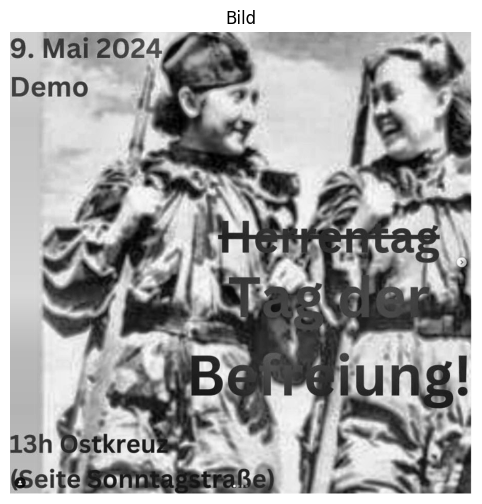

In [15]:
import numpy as np
import cv2 as cv
 
img = cv.imread('../../data/images/insta_images/0007.jpg', cv.IMREAD_GRAYSCALE)
assert img is not None, "file could not be read, check with os.path.exists()"
 
# create a CLAHE object (Arguments are optional).
clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl1 = clahe.apply(img)
 
#cv.imwrite('clahe_2.jpg',cl1)
show_image(cl1)

In [19]:
import os
import cv2
import numpy as np
import pandas as pd
from easyocr import Reader
import sys # ermöglicht Zugriff auf übergeordnetes Verzeichnis
sys.path.append(os.path.abspath("../../utils"))
from funktionen import cer_for_matching, match_gt_to_ocr, calculate_char_accuracy, calculate_word_accuracy, calculate_wer,calculate_cer, CER_THRESHOLD



# 1. CLAHE
def apply_clahe(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(gray)

# 2. Varianten
def generate_variants(image):
    variants = []
    alphas = [0.7, 1.5, 2.3, 3.5]
    betas = [-50, 0, 50, 120]
    for alpha in alphas:
        for beta in betas:
            adjusted = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
            variants.append((adjusted, f"alpha={alpha}, beta={beta}"))
    return variants

# 3. OCR mit Filter
def run_easyocr(image, reader, conf_thresh=0.4):
    results = reader.readtext(image)
    return [r for r in results if r[2] >= conf_thresh]

# 4. Merge nach Bounding-Box-Mittelpunkt
def merge_results(all_results, distance_thresh=30):
    merged = []
    for res in all_results:
        (tl, tr, br, bl), text, conf = res
        center = ((tl[0] + br[0]) / 2, (tl[1] + br[1]) / 2)

        # Prüfen, ob ein vorhandenes Ergebnis in der Nähe ist
        updated = False
        for i, (existing_text, existing_conf, existing_box) in enumerate(merged):
            existing_center = ((existing_box[0][0] + existing_box[2][0]) / 2,
                               (existing_box[0][1] + existing_box[2][1]) / 2)
            dist = np.linalg.norm(np.array(center) - np.array(existing_center))

            if dist < distance_thresh:
                # Wenn das neue Ergebnis besser ist → ersetzen
                if conf > existing_conf:
                    merged[i] = (text, conf, (tl, tr, br, bl))
                updated = True
                break

        if not updated:
            merged.append((text, conf, (tl, tr, br, bl)))

    return merged

# Evaluation
def evaluate_ocr_with_metrics(gt_lines, ocr_lines):
    matches = match_gt_to_ocr(gt_lines, ocr_lines)
    total_gt = len(gt_lines)
    total_ocr = len(ocr_lines)
    total_matches = sum(1 for (_, ocr_idx) in matches if ocr_idx is not None)

    cer_list = []
    wer_list = []

    for gt_idx, ocr_idx in matches:
        gt = gt_lines[gt_idx]
        pred = ocr_lines[ocr_idx] if ocr_idx is not None else ""
        cer_list.append(calculate_cer(gt, pred))
        wer_list.append(calculate_wer(gt, pred))

    mean_cer = sum(cer_list) / total_gt if total_gt else None
    mean_wer = sum(wer_list) / total_gt if total_gt else None

    return {
        "gt_lines": total_gt,
        "ocr_lines": total_ocr,
        "matched_lines": total_matches,
        "mean_cer": mean_cer,
        "mean_wer": mean_wer
        
    }



# 5. Hauptfunktion für ein Bild
def preprocess_image(image):
    # In Graustufen konvertieren
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image
    
    # Rauschunterdrückung (optional optimierbar)
    denoised = cv2.bilateralFilter(gray, d=9, sigmaColor=75, sigmaSpace=75)

    # Hintergrundschätzung und Subtraktion
    background = cv2.medianBlur(denoised, 21)
    diff = cv2.absdiff(denoised, background)

    # Normierung (optional kontrastverstärkend)
    norm = cv2.normalize(diff, None, 0, 255, cv2.NORM_MINMAX)

    return norm


def process_image(image_path, reader):
    image = cv2.imread(image_path)

    # NEU: Vorverarbeitung bei unruhigem Hintergrund
    preprocessed = preprocess_image(image)

    # Dann CLAHE auf vorbereitete Version
    clahe_img = apply_clahe(preprocessed)

    # Varianten erzeugen (verschiedene alpha/beta)
    variants = generate_variants(clahe_img)

    # OCR über alle Varianten
    all_results = []
    for img, desc in variants:
        results = run_easyocr(img, reader)
        all_results.extend(results)

    merged = merge_results(all_results)
    return [text for text, conf, box in merged]


# 6. Batch-Verarbeitung + CSV Export
def process_folder_with_eval(image_folder, gt_dict, output_csv):
    reader = Reader(['de', 'en'])
    results = []

    for fname in os.listdir(image_folder):
        if not fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue

        img_path = os.path.join(image_folder, fname)
        print(f"🔍 Verarbeite: {fname}")
        try:
            ocr_lines = process_image(img_path, reader)  # EasyOCR-Ausgabe
            gt_lines = gt_dict.get(fname, [])

            eval_result = evaluate_ocr_with_metrics(gt_lines, ocr_lines)
            eval_result.update({
                "file_name": fname,
                "ocr_easyocr_clahe": ocr_lines
            })

            results.append(eval_result)

        except Exception as e:
            print(f"⚠️ Fehler bei {fname}: {e}")

    df = pd.DataFrame(results)
    df.to_csv(output_csv, index=False)
    print(f"\n✅ Export abgeschlossen: {output_csv} (Dateien: {len(df)})")

In [2]:
import os
import json
JSON_PATH = "../../data/original_text.json"

with open(JSON_PATH, "r", encoding="utf-8") as f:
    all_data = json.load(f)

gt_dict = {e["file_name"]: e.get("lines", []) for e in all_data if "file_name" in e}

process_folder_with_eval("../../data/images/insta_images", gt_dict, "../../data/OCR/easyocr/ocr_evaluation_clahe2.csv")


NameError: name 'process_folder_with_eval' is not defined

In [21]:
import pandas as pd

df = pd.read_csv("../../data/OCR/easyocr/ocr_evaluation_clahe2.csv")
df.head()

,gt_lines,ocr_lines,matched_lines,mean_cer,mean_wer,file_name,ocr_easyocr_clahe
0,7,6,1,0.904762,0.952381,0071.jpg,"['29', 'Store:', 'Grfir:', '2;4;', 'L', 'Augst..."
1,7,5,0,1.000000,1.000000,0059.jpg,"['8', 'FLINTA', 'KEZ', 'MARZ', '19']"
2,13,15,8,0.480184,0.593590,0111.jpg,"['2', 'Podium:', 'Martin Krauß', '(Sportjournc..."
3,8,4,3,0.681110,0.731250,0139.jpg,['WIR BLEIBEN DABEI: SOZIALE LOSUNGEN FÜR SOZI...
4,5,11,0,1.000000,1.000000,0110.jpg,"['100', '2', '28.122', '5', '63', '28.14', '51..."


In [22]:
df["recognition_rate"] = df["matched_lines"] / df["gt_lines"]

In [23]:
# Durchschnitt berechnen
mean_cer = df["mean_cer"].mean()
mean_wer = df["mean_wer"].mean()
mean_ER = df["recognition_rate"].mean()

# Ausgabe
print(f"Durchschnittswerte ganzer Datensatz:")
print(f"Erkennungsrate: {mean_ER:.3f}")
print(f"CER: {mean_cer:.3f}")
print(f"WER: {mean_wer:.3f}")

Durchschnittswerte ganzer Datensatz:
Erkennungsrate: 0.419
CER: 0.629
WER: 0.779


--> Werte sind schlechter, Evaluation wird nicht fortgeführt